<a href="https://colab.research.google.com/github/ParsaPNT128/yelp-recommender/blob/main/yelp_rs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Yelp Recommender System**

## **Data Collection**

In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d yelp-dataset/yelp-dataset

Dataset URL: https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset
License(s): other
100% 4.07G/4.07G [00:48<00:00, 112MB/s]
100% 4.07G/4.07G [00:48<00:00, 90.9MB/s]


In [ ]:
!unzip /content/yelp-dataset.zip

Archive:  /content/yelp-dataset.zip
  inflating: Dataset_User_Agreement.pdf  
  inflating: yelp_academic_dataset_business.json  
  inflating: yelp_academic_dataset_checkin.json  
  inflating: yelp_academic_dataset_review.json  
  inflating: yelp_academic_dataset_tip.json  
  inflating: yelp_academic_dataset_user.json  


## **Data Preparation**

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=be264620b08b639a515d36ab443e45b6006a4be3e09bc0f04eddefefcdc59302
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.ml import Pipeline
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession


spark = SparkSession.builder \
    .appName("Yelp Restaurant Recommendation System") \
    .getOrCreate()

In [ ]:
business_df = spark.read.json("yelp_academic_dataset_business.json")
review_df = spark.read.json("yelp_academic_dataset_review.json")
user_df = spark.read.json("yelp_academic_dataset_user.json")

In [ ]:
business_df.show(5)
review_df.show(5)
user_df.show(5)

+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|         city|               hours|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|1616 Chapala St, ...|{NULL, NULL, NULL...|Pns2l4eNsfO8kk83d...|Doctors, Traditio...|Santa Barbara|                NULL|      0|34.4266787|-119.7111968|Abby Rappoport, L...|      93101|           7|  5.0|   CA|
|87 Grasso Plaza S...|{NULL, NULL, NULL...|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|       Affton|{8:0-18:30, 0:0-0...|      1| 38.551126|  -90.335695|    

**Selecting Columns**

In [ ]:
business_cols = ['business_id', 'name', 'categories', 'city', 'latitude', 'longitude', 'is_open']
review_cols = ['review_id', 'user_id', 'business_id', 'stars', 'text']
user_cols = ['user_id', 'review_count']

In [ ]:
business_df = business_df.select(business_cols)
review_df = review_df.select(review_cols)
user_df = user_df.select(user_cols)

**Filtering**

In [ ]:
from pyspark.sql.functions import col

business_df = business_df.filter(business_df["is_open"] == 1)

**Dropping Columns**

In [ ]:
business_df = business_df.drop("is_open")

In [ ]:
business_df = business_df.dropna()
review_df = review_df.dropna()
user_df = user_df.dropna()

**Adding New ID**

In [ ]:
business_newid_df = spark.createDataFrame(business_df.rdd.map(lambda x: x[0]).zipWithIndex(), \
        StructType([StructField("business_id", StringType(), True),StructField("businessId", IntegerType(), True)]))

a = business_df.alias("a")
b = business_newid_df.alias("b")

business_new_df = a.join(b, col("a.business_id") == col("b.business_id"), 'inner') \
             .select([col('a.'+xx) for xx in a.columns] + [col('b.businessId')])

business_new_df.select('businessId','business_id', 'name', 'categories', 'city', 'latitude', 'longitude', 'is_open').show()

In [ ]:
user_newid_df = spark.createDataFrame(user_df.rdd.map(lambda x: x[0]).zipWithIndex(), \
        StructType([StructField("user_id", StringType(), True),StructField("userId", IntegerType(), True)]))

a = user_df.alias("a")
b = user_newid_df.alias("b")

user_new_df = a.join(b, col("a.user_id") == col("b.user_id"), 'inner') \
             .select([col('a.'+xx) for xx in a.columns] + [col('b.userId')])

user_new_df.select('userId','user_id', 'name').show()

In [ ]:
new_review_df = review_df.select('user_id', 'business_id', 'stars', 'text')

a = new_review_df.alias("a")
b = user_newid_df.alias("b")

review_userId_df = a.join(b, col("a.user_id") == col("b.user_id"), 'inner') \
                     .select([col('a.'+xx) for xx in a.columns] + [col('b.userId')])

a = review_userId_df.alias("a")
b = business_newid_df.alias("b")

review_userId_businessId_df = a.join(b, col("a.business_id") == col("b.business_id"), 'inner') \
                         .select([col('a.'+xx) for xx in a.columns] + [col('b.businessId')])

review_userId_businessId_df.show()

## **Data Exploration**

In [ ]:
business_df.printSchema()
review_df.printSchema()
user_df.printSchema()

In [ ]:
business_df.describe().show()
review_df.describe().show()
user_df.describe().show()

+-------+--------------------+--------------------+--------------------+-----------+------------------+------------------+
|summary|         business_id|                name|          categories|       city|          latitude|         longitude|
+-------+--------------------+--------------------+--------------------+-----------+------------------+------------------+
|  count|              119603|              119603|              119603|     119603|            119603|            119603|
|   mean|                NULL|  1328.6666666666667|                NULL|       NULL|36.621838060656984|-89.46646264373256|
| stddev|                NULL|   851.4687702239388|                NULL|       NULL| 5.884550067556388|14.972558394818144|
|    min|---kPU91CF4Lq2-Wl...|        Grow Academy|3D Printing, Loca...|AB Edmonton|         27.555127|       -120.095137|
|    max|zzw66H6hVjXQEt0Js...|​Silent Stay Medi...|Zoos, Tours, Arts...|    ​Lithia|        53.6791969|    -73.2004570502|
+-------+-------

In [ ]:
from pyspark.sql.functions import explode, split, col

business_exploded = business_new_df.withColumn("category", explode(split("categories", ",\s*")))
category_counts = business_exploded.groupBy("category").count().orderBy(col("count").desc())

category_counts.show()

+--------------------+-----+
|            category|count|
+--------------------+-----+
|         Restaurants|34987|
|                Food|20419|
|            Shopping|20186|
|       Home Services|13322|
|       Beauty & Spas|12263|
|    Health & Medical|11046|
|      Local Services|10138|
|          Automotive| 9879|
|           Nightlife| 8379|
|Event Planning & ...| 8173|
|                Bars| 7528|
|         Active Life| 6496|
|          Sandwiches| 6075|
|American (Traditi...| 5531|
|           Fast Food| 5516|
|     Hotels & Travel| 5123|
|               Pizza| 5090|
|       Home & Garden| 5022|
|         Auto Repair| 5003|
|        Coffee & Tea| 4954|
+--------------------+-----+
only showing top 20 rows



In [ ]:
reviews_per_business = review_df.groupBy("business_id").count().orderBy(col("count").desc())

reviews_per_business.show()

+--------------------+-----+
|         business_id|count|
+--------------------+-----+
|_ab50qdWOk0DdB6XO...| 7673|
|ac1AeYqs8Z4_e2X5M...| 7516|
|GXFMD0Z4jEVZBCsbP...| 6160|
|ytynqOUb3hjKeJfRj...| 5778|
|oBNrLz4EDhiscSlbO...| 5264|
|iSRTaT9WngzB8JJ2Y...| 5254|
|VQcCL9PiNL_wkGf-u...| 5146|
|_C7QiQQc47AOEv4PE...| 4969|
|GBTPC53ZrG1ZBY3DT...| 4661|
|6a4gLLFSgr-Q6CZXD...| 4480|
|PP3BBaVxZLcJU54uP...| 4293|
|1b5mnK8bMnnju_cvU...| 4247|
|I_3LMZ_1m2mzR0oLI...| 4093|
|VaO-VW3e1kARkU9bP...| 4034|
|qb28j-FNX1_6xm7u3...| 3971|
|gTC8IQ_i8zXytWSly...| 3917|
|yPSejq3_erxo9zdVY...| 3889|
|wz8ZPfySQczcPgSyd...| 3634|
|VVH6k9-ycttH3TV_l...| 3633|
|IkY2ticzHEn4QFn8h...| 3428|
+--------------------+-----+
only showing top 20 rows



In [ ]:
reviews_businesses = review_df.join(business_df, "business_id", how="inner")
most_reviewed_cities = reviews_businesses.groupBy("city").count().orderBy(col("count").desc())
most_reviewed_cities = most_reviewed_cities.withColumnRenamed("count", "Number Of Reviews")

most_reviewed_cities.show(10)

+-------------+-----------------+
|         city|Number Of Reviews|
+-------------+-----------------+
| Philadelphia|           744065|
|  New Orleans|           536726|
|        Tampa|           380084|
|    Nashville|           377372|
|       Tucson|           341433|
|         Reno|           295454|
| Indianapolis|           291535|
|Santa Barbara|           224006|
|  Saint Louis|           196382|
|        Boise|            93314|
+-------------+-----------------+
only showing top 10 rows



**Top 20 Cities With The Most Businesses**

In [ ]:
!pip install matplotlib

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

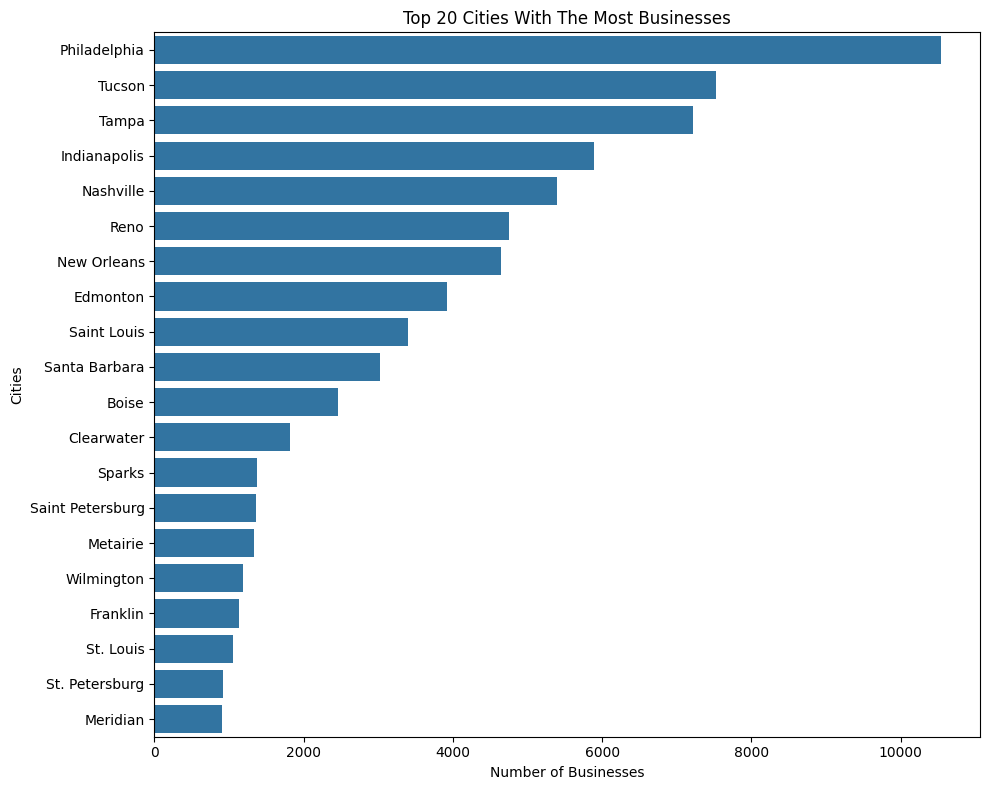

In [ ]:
from pyspark.sql.functions import col

most_businesses_cities = business_df.groupBy("city").count().orderBy(col("count").desc())
top_20_cities = most_businesses_cities.limit(20)
top_20_cities_pd = top_20_cities.toPandas()

plt.figure(figsize=(10, 8))
sns.barplot(x="count", y="city", data=top_20_cities_pd)
plt.title("Top 20 Cities With The Most Businesses")
plt.xlabel("Number of Businesses")
plt.ylabel("Cities")
plt.tight_layout()
plt.show()

**Reviews Word Cloud**

In [ ]:
!pip install wordcloud

In [ ]:
from wordcloud import WordCloud, STOPWORDS
from pyspark.sql.functions import col

def create_wordcloud(df):
  review_list = df.select('text').toPandas()['text'].tolist()
  all_review = ''.join(review_list)

  wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = STOPWORDS,
                min_font_size = 10).generate(all_review)

  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

business = input("Enter the business name: ")
business_data = business_df.filter(business_df["name"] == business)

if business_data.count():
  review_data = business_data.join(review_df, on="business_id", how="inner")

  if b.count():
    create_wordcloud(review_data)

  else:
    print("No reviews found.")

else:
  print("Business not found.")